In [1]:
import os
import sys
print(sys.version)   # Python version information

3.4.4 |Anaconda 2.4.0 (64-bit)| (default, Jan 11 2016, 13:54:01) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
from sympy import *  # Symbolic mathematics
import sympy

In [3]:
import numpy as np   # N-Dimensional arrays and numerical routines
import numba
import scipy         # Numerical routines

In [4]:
from scipy.stats import truncnorm

In [5]:
from sympy import abc       # Symbolic variables
from sympy import pi as Pi  # Symbolic pi
from sympy import I as I    # Symbolic imaginary unit

In [6]:
from IPython.display import display

In [7]:
sympy.interactive.printing.init_printing(use_latex='mathjax')

In [8]:
np.set_printoptions(precision=5, threshold=6, edgeitems=3, linewidth=75, 
                    suppress=False, nanstr=None, infstr=None, 
                    formatter=None)

# Adjusting force

\begin{align}
\mathbf{f}_{i}^{adj} &= \frac{m_{i}}{\tau_{i}^{adj}} (v_{i}^{0} \cdot \hat{\mathbf{e}}_{i}^{0} - \mathbf{v}_{i}) 
\end{align}

# Social Force

\begin{align}
\mathbf{f}_{ij}^{pow} &= - \left(\frac{k}{a \tau^{2}}\right) 
\left(\frac{2}{\tau} + \frac{1}{\tau_{0}}\right) 
\exp\left (-\frac{\tau}{\tau_{0}}\right )
\left(\mathbf{v}_{ij} -\frac{a \mathbf{x}_{ij} + b \mathbf{v}_{ij}}{d} \right)
\end{align}

\begin{align}
a &= \mathbf{v}_{ij} \cdot \mathbf{v}_{ij} \\
b &= -\mathbf{x}_{ij} \cdot \mathbf{v}_{ij} \\
c &= \mathbf{x}_{ij} \cdot \mathbf{x}_{ij} - r_{ij}^{2} \\
d &= \sqrt{b^{2} - a c} \\
\tau &= \frac{b - d}{a} > 0.
\end{align}

In [ ]:
x = symbols('\|x\|', real=True, positive=True)
v = symbols('\|v\|', real=True, positive=True)
r = symbols('r', real=True, positive=True)
theta = symbols('theta', real=True)

In [ ]:
a = v**2
b = - x * v * cos(theta)
c = x**2 - r**2

In [ ]:
d = simplify(sqrt(b**2 - a * c))

In [ ]:
tau = simplify((b - d) / a)

In [ ]:
a, b, c, d

In [ ]:
tau

$\tau$ undefined

In [ ]:
tau.subs(theta, Pi/2)

$\tau_{min}$

In [ ]:
tau.subs(theta, -Pi)

# Contact Force

\begin{align}
\mathbf{f}_{ij}^{c} &= 
\begin{cases}
h_{ij} \cdot \left(\mu \cdot \hat{\mathbf{n}}_{ij} - \kappa \cdot \left(\mathbf{v}_{ji} \cdot \hat{\mathbf{t}}_{ij}\right) \hat{\mathbf{t}}_{ij}\right) & h_{ij} > 0 \\
0 & \text{otherwise}
\end{cases}
\end{align}

# Random fluctuation $ \boldsymbol{\xi}_{i} $ 

\begin{align}
\boldsymbol{\xi}_{i} &= f \left[\begin{matrix}\cos{\left (\theta \right )} & \sin{\left (\theta \right )}\end{matrix}\right] & f \in \mathcal{U}(0, f_{max}), \quad \theta \in [0, \pi) \\
\end{align}

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

In [68]:
myclip_a, myclip_b, my_mean, my_std = -3*0.1, 3*0.1, 0, 0.1

In [69]:
a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

In [70]:
a, b

(-3.0000000000000004, 3.0000000000000004)

In [80]:
arr = truncnorm.rvs(0, 3, loc=0, scale=0.1, size=10000)

In [84]:
truncnorm.std(-3, 3, loc=0, scale=0.1)

0.0986578392558

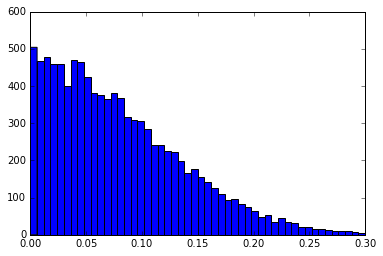

In [82]:
plt.hist(arr, bins=50);

In [90]:
angle = np.random.uniform(0, 2 * np.pi, size=10)
np.array((np.cos(angle), np.sin(angle)))

array([[ 0.47213, -0.96233, -0.9191 , ..., -0.57481, -0.90586, -0.76258],
       [-0.88153,  0.27189,  0.39403, ...,  0.81829,  0.42357, -0.6469 ]])

In [91]:
_ * np.arange(10)

array([[ 0.     , -0.96233, -1.8382 , ..., -4.02367, -7.24691, -6.8632 ],
       [-0.     ,  0.27189,  0.78805, ...,  5.72801,  3.38856, -5.82207]])

In [92]:
_.T

array([[ 0.     , -0.     ],
       [-0.96233,  0.27189],
       [-1.8382 ,  0.78805],
       ..., 
       [-4.02367,  5.72801],
       [-7.24691,  3.38856],
       [-6.8632 , -5.82207]])

In [93]:
_.shape

(10, 2)